# MIP model baseline

In [1]:
import sqlite3
import pandas as pd
con = sqlite3.connect("E:\Code\Calliope\db\historical.db")

In [3]:
from calliope.prices import construct_prices_from_mms, construct_prices_from_merit_order_csv, get_prices_over_horizon
from calliope.optimisation import config, mip_energyonly, mip_joint

In [3]:
prices = construct_prices_from_merit_order_csv(
    path='E:/Code/Calliope/notebooks/merit_order_prices.csv', 
    region_id= 'NSW1', 
    start_date = '2019/01/01', 
    end_date='2019/01/03', 
    create_agc=True
)

In [9]:
prices = construct_prices_from_mms(con=con, region_id= 'VIC1', start_date='2023/01/01', end_date='2023/01/31', create_agc=True)

In [36]:
import matplotlib.pyplot as plt

prices_df = prices.to_dataframe()

prices_df['PeriodID'] = ((prices_df['SETTLEMENTDATE'].dt.hour * 12) + (prices_df['SETTLEMENTDATE'].dt.minute * (12/5/12)) + 1
).astype(int)

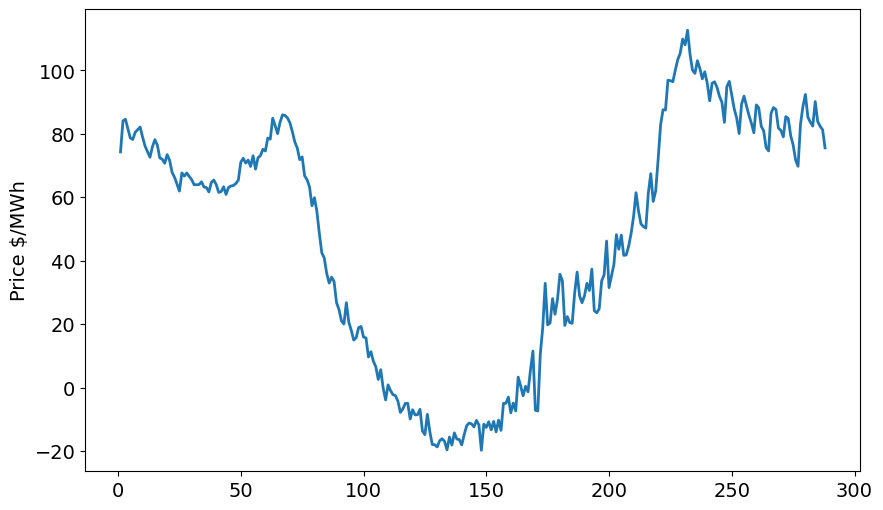

In [57]:
fig, ax = plt.subplots(figsize=(10,6))

ax.plot(prices_df.groupby('PeriodID').ROP.mean(), linewidth=2)
ax.set_ylabel('Price $/MWh', fontsize=14)
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)

In [28]:
bess_config = config.load_config('E:/Code\Calliope/scripts/config.yml')
#model = mip_energyonly.MixedIntegerESSModelEnergyOnlyPriceTaker(bess_config)
model = mip_joint.MixedIntegerESSModelJointPriceTaker(bess_config, solver_backend='GUROBI')

model.set_parameters(prices)
model.build()
model.solve()

Solving with Gurobi library version 11.0.2

An optimal solution has been found to the problem.


In [17]:
model.get_unit_info()

,unit,dispatch_type,region,loss_factor
0,CSBG1,generator,VIC1,0.99
1,CSBL1,load,VIC1,0.99


In [21]:
results = model.to_dataframe()

<Axes: >

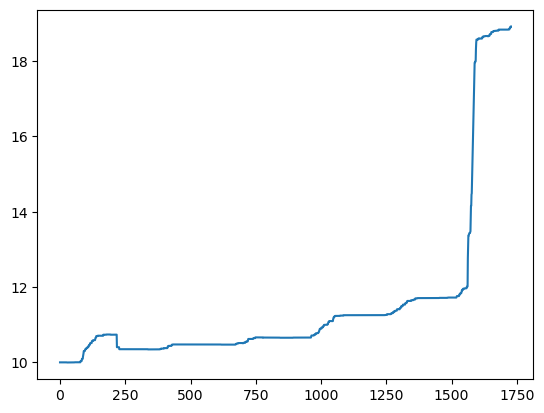

In [22]:
results.SOC.plot()


In [26]:
results.columns

Index(['SETTLEMENTDATE', 'REGIONID', 'ROP', 'RAISE6SECROP', 'RAISE60SECROP',
       'RAISE5MINROP', 'RAISEREGROP', 'LOWER6SECROP', 'LOWER60SECROP',
       'LOWER5MINROP', 'LOWERREGROP', 'CHARGE', 'CHARGE_FROM_LOWERREG',
       'CUMULATIVE_DISCHARGE', 'DISCHARGE', 'DISCHARGE_FROM_RAISEREG',
       'IS_CHARGE', 'IS_DICHARGE', 'LOWERDELAY', 'LOWERFAST',
       'LOWERREGULATION', 'LOWERSLOW', 'RAISEDELAY', 'RAISEFAST',
       'RAISEREGULATION', 'RAISESLOW', 'SOC'],
      dtype='object')